# The Split-Bregman Algorithm: Sparsity Enforcing Inversions

@Author: Francesco Picetti - francesco.picetti@polimi.it

In this notebook we will show the Split-Bregman algorithm,
as described by [Goldstein and Osher, 2009](https://doi.org/10.1137/080725891).

In its generalized unconstrained formulation (the same we handle in this library), this algorithm
takes what we call `ProblemLinearReg` (see `pyProblem.py`):

\begin{equation}
    \arg \min_\mathbf{m} \Vert  \mathbf{A} \mathbf{m} - \mathbf{d}\Vert_2^2 + \sum_i \varepsilon_{L2,i}\Vert \mathbf{R}_{L2,i} \mathbf{m} - \mathbf{p}_i\Vert_2^2 + \sum_i \varepsilon_{L1,i}\Vert \mathbf{R}_{L1,i} \mathbf{m}\Vert_1,
\end{equation}

being $\mathbf{m}$ our model, $\mathbf{d}$ the observed data, $\mathbf{A}$ a linear modeling operator,
$\mathbf{R}_{L2,i}$ the $i$-th linear regularizer to which we associate a prior $\mathbf{p}_i$ along with its weight $\varepsilon_{L2,i}$,
$\mathbf{R}_{L1,i}$ the $i$-th sparsity promoting regularizer and its weight $\varepsilon_{L1,i}$.

#### Import modules

In [1]:
# Importing necessary modules
import numpy as np
import occamypy

# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


##  Example 1:  1D Ricker Deconvolution

In this example we want to invert a 1D seismic trace for the Earth's reflectivity.
We suppose the wavelet to be known, yielding  to a deterministic deconvolution problem.

In [2]:
# load wavelet
ricker = occamypy.VectorIC(np.load("./data/ricker20.npy"))
nt = 51.
ot = 0.
dt = 1.

# load reflectivity
model = occamypy.VectorIC(np.load("./data/reflectivity1D.npy"))

# instantating operator
A = occamypy.ConvND(model, ricker)

# Generating true recorded trace
data = A * model

/Users/francesco/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/francesco/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


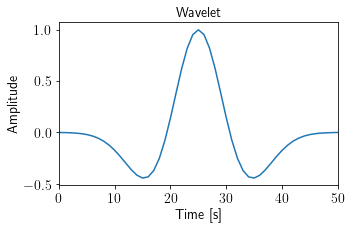

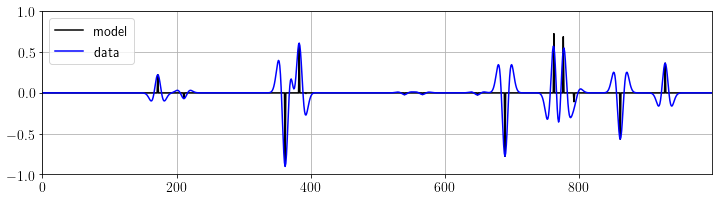

In [3]:
fig, ax = plt.subplots(figsize=(5,3))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), ricker.getNdArray())
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(model.getNdArray(), 'k',  label='model')
plt.plot(data.getNdArray(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-1., 1.)
plt.legend()
plt.grid(True)
plt.show()

#### Solve with Conjugate Gradient

Conjugate gradient is a fast and powerful adjoint-state algorithm for solving problems in the form:

\begin{equation}
    \hat{\mathbf{m}} = \arg \min_\mathbf{m} \Vert \mathbf{A}\mathbf{m} - \mathbf{d}\Vert_2^2
\end{equation}

In [4]:
# instantiate a linear L2 problem
problemCG = occamypy.LeastSquares(model.clone().zero(), data, A)

# define the solver with 10'000 iterations
CG = occamypy.CG(occamypy.BasicStopper(10000))

# solve the problem
CG.run(problemCG, verbose=False)

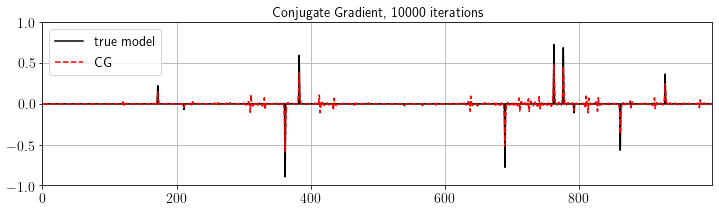

In [5]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemCG.model.getNdArray(), 'r--', label="CG")
plt.title('Conjugate Gradient, %d iterations' % CG.stopper.niter)
plt.ylim(-1., 1.)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

#### Impose sparsity in the solution: FISTA

Iterative Shrinkage-Thresholding Algorithms solve the so-called LASSO problem:
\begin{equation}
    \hat{\mathbf{m}} = \arg \min_\mathbf{m} \Vert \mathbf{A}\mathbf{m} - \mathbf{d}\Vert_2^2 + \lambda \Vert \mathbf{m}\Vert_1
\end{equation}

If we provide the operator's maximum eigenvalue $\eta$ we can build a fast version
of this algorithm by imposing the step $\alpha < 1/\eta^2$ as proposed in [Beck and Teboulle, 2009](https://doi.org/10.1137/080716542).

In [6]:
# compute maximum eigenvalue
maxeig = A.powerMethod()
print('FISTA α=%.6e' % (1/(maxeig**2)))

# define the LASSO problem
problemFISTA = occamypy.Lasso(model.clone().zero(), data, A, lambda_value=1, op_norm=maxeig**2)

# instantiate the fast solver with 1000 iterations
FISTA = occamypy.ISTA(occamypy.BasicStopper(1000), fast=True)

# solve the problem
FISTA.run(problemFISTA, verbose=False)

FISTA α=9.291507e-03


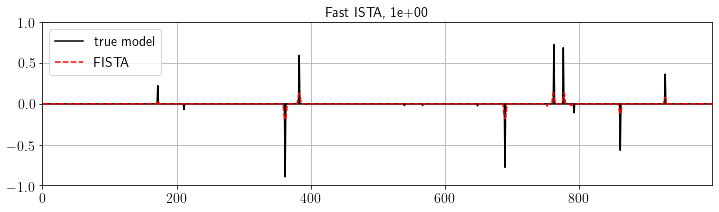

In [7]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemFISTA.model.getNdArray(), 'r--', label="FISTA")
plt.title('Fast ISTA, %.e' % problemFISTA.lambda_value)
plt.ylim(-1, 1)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

Note that FISTA is able to recover the model's kinematics but not the true amplitude.
Indeed, this algorithm is very sensitive to $\lambda$ parameter.
Let's try another solver.

#### Split-Bregman for LASSO problem

In [8]:
# define the Linear Regularized Problem
problemSB = occamypy.RegularizedLeastSquares(model.clone().zero(), data, A,
                             regsL1=occamypy.IdentityOp(model), epsL1=.1)

# instantiate the Split-Bregman solver
SB = occamypy.SplitBregman(occamypy.BasicStopper(1000), niter_inner=5, niter_solver=15,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)

# solve the problem
SB.run(problemSB, verbose=True, inner_verbose=False)

##########################################################################################
			SPLIT-BREGMAN ALGORITHM

	Restart folder: /tmp/restart_2020-07-20T12-18-51.079303/
	Modeling Operator:	ConvScipy
	Inner iterations:	5
	Solver iterations:	15
	L1 Regularizer ops:		Identity
	L1 Regularizer weights:	1.00e-01
	Bregman update weight:	1.00e+00
	Using warm start option for inner problem
##########################################################################################

iter = 0000, obj = 1.04371e+01, df_obj = 1.04e+01, reg_obj = 0.00e+00, resnorm = 4.57e+00
iter = 0001, obj = 8.54466e-01, df_obj = 1.35e-03, reg_obj = 8.53e-01, resnorm = 7.92e-01
iter = 0002, obj = 6.83819e-01, df_obj = 1.24e-03, reg_obj = 6.83e-01, resnorm = 8.82e-01
iter = 0003, obj = 6.68903e-01, df_obj = 6.91e-04, reg_obj = 6.68e-01, resnorm = 9.81e-01
iter = 0004, obj = 6.29745e-01, df_obj = 7.51e-04, reg_obj = 6.29e-01, resnorm = 1.04e+00
iter = 0005, obj = 6.16897e-01, df_obj = 4.92e-04, reg_obj = 6.16e

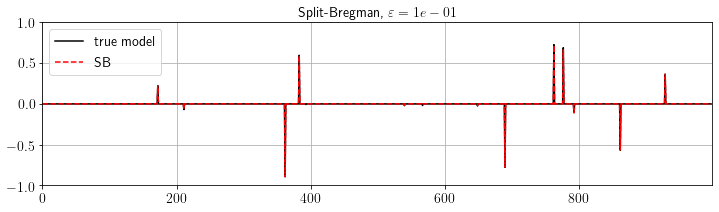

In [9]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(model.getNdArray(), 'k', label="true model")
plt.plot(problemSB.model.getNdArray(), 'r--', label="SB")
plt.title(r'Split-Bregman, $\varepsilon=%.e$' % problemSB.epsL1[0])
plt.ylim(-1, 1)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.show()

The results is much better than FISTA output: the dynamics is almost-perfectly recovered.


##  Example 2:  1D Velocity Deconvolution

Now we create a synthetic velocity profile and suppose to have recorded a smooth version of it.
The deconvolution problem aims at recovering the sharp model, and this is done by using a Total Variation regularizer.

In [10]:
# create the true model
nx = 201
x = occamypy.VectorIC((nx,)).zero()
x.getNdArray()[20:30] = 10.
x.getNdArray()[50:75] = -5.
x.getNdArray()[100:150] = 2.5
x.getNdArray()[175:180] = 7.5

# instantiate the blurring operator
G = occamypy.GaussianFilter(x, 2.0)

# simulate data
y = G * x

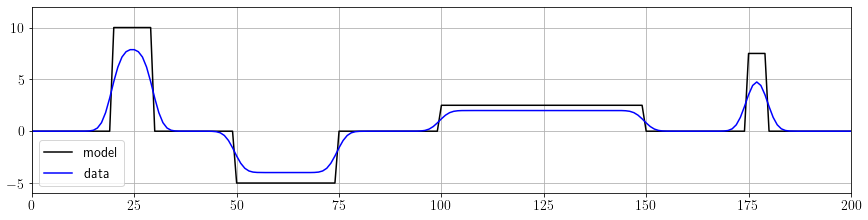

In [11]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'k',  label='model')
plt.plot(y.getNdArray(), 'b',  label='data')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-6, 12)
plt.legend()
plt.grid(True)
plt.tight_layout(.5)
plt.show()

As we can see, the model presents some flat regions. Let's have a look to its first derivative:

In [12]:
D = occamypy.FirstDerivative(x, stencil='forward')
Dx = D * x

/Users/francesco/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


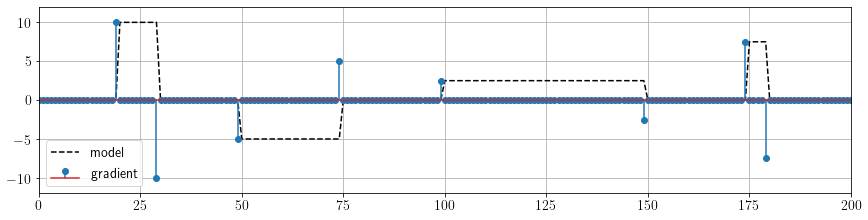

In [13]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), '--k',  label='model')
plt.stem(Dx.getNdArray(), label='gradient')
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim(-12, 12)
plt.legend()
plt.grid(True)
plt.tight_layout(.5)
plt.show()

The model derivative is sparse! We can set up a SplitBregman solver:

In [14]:
problem = occamypy.RegularizedLeastSquares(x.clone().zero(), y, G, regsL1=D, epsL1=.1)

SB = occamypy.SplitBregman(occamypy.BasicStopper(1000), niter_inner=5, niter_solver=10,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)

SB.run(problem, verbose=False, inner_verbose=False)

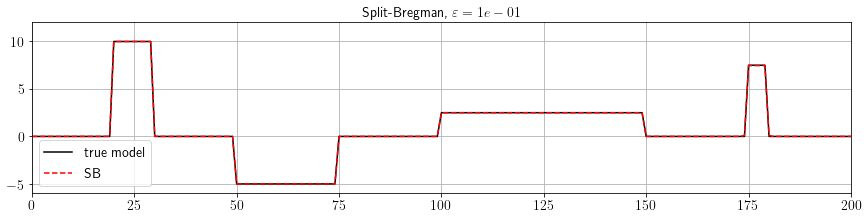

In [15]:
fig, ax = plt.subplots(figsize=(12, 3))
plt.plot(x.getNdArray(), 'k', label="true model")
plt.plot(problem.model.getNdArray(), 'r--', label="SB")
plt.title(r'Split-Bregman, $\varepsilon=%.e$' % problem.epsL1[0])
plt.ylim(-6, 12)
ax.autoscale(enable=True, axis='x', tight=True)
plt.grid(True)
plt.legend()
plt.tight_layout(.5)
plt.show()

##  Example 3: 2D Phantom Deconvolution

In this example we reconstruct a phantom CT image starting from a blurred acquisition.
Again, we regularize the inversion by imposing the first derivative to be sparse.

Model:

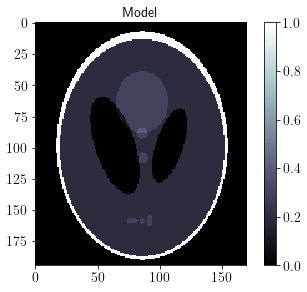

In [16]:
x = occamypy.VectorIC(np.load('./data/shepp_logan_phantom.npy', allow_pickle=True).astype(np.float32))
x = x.scale(1 / 255.)

plt.figure(figsize=(5, 4))
plt.imshow(x.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.title('Model')
plt.tight_layout(.5)
plt.show()

Data:

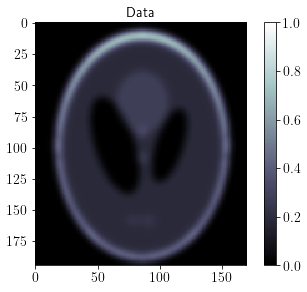

In [17]:
Op = occamypy.GaussianFilter(x, [3, 3])
y = Op * x

plt.figure(figsize=(5, 4))
plt.imshow(y.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.title('Data')
plt.tight_layout(.5)
plt.show()

Problem and solver:

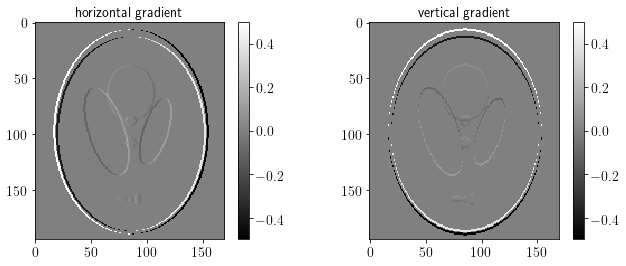

In [18]:
G = occamypy.Gradient(x)
Gx = G*x

plt.figure(figsize=(11, 4))
plt.subplot(121), plt.title('horizontal gradient')
plt.imshow(Gx.vecs[1].getNdArray(), cmap='gray'), plt.colorbar()
plt.subplot(122), plt.title('vertical gradient')
plt.imshow(Gx.vecs[0].getNdArray(), cmap='gray'), plt.colorbar()
plt.show()

In [19]:
problemSB = occamypy.RegularizedLeastSquares(x.clone().zero(), y, Op, regsL1=G, epsL1=1e-3)
SB = occamypy.SplitBregman(occamypy.BasicStopper(niter=200), niter_inner=5, niter_solver=15,
                        linear_solver='LSQR', breg_weight=1., warm_start=True)
SB.setDefaults(save_obj=True, save_model=True)
SB.run(problemSB, verbose=False, inner_verbose=False)

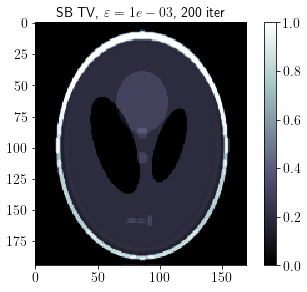

In [20]:
plt.figure(figsize=(5, 4))
plt.imshow(problemSB.model.getNdArray(), cmap='bone', vmin=x.min(), vmax=x.max()), plt.colorbar()
plt.title(r'SB TV, $\varepsilon=%.e$, %d iter' % (problemSB.epsL1[0], SB.stopper.niter))
plt.tight_layout(.5)
plt.show()

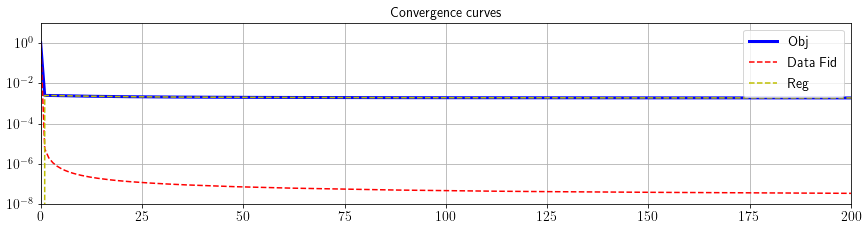

In [27]:
plt.figure(figsize=(12, 3))
plt.semilogy(SB.obj / SB.obj[0], 'b', lw=3, label='Obj')
plt.semilogy(np.asarray(SB.obj_terms)[:, 0] / SB.obj[0], 'r--', label='Data Fid')
plt.semilogy(np.asarray(SB.obj_terms)[:, 1] / SB.obj[0], 'y--', label='Reg')
plt.legend(), plt.grid(True)
plt.xlim(0, 200), plt.ylim(1e-8,1e1)
plt.tight_layout(.5)
plt.title('Convergence curves')
plt.show()